## Load Data

In [36]:
import os
import json
import datetime
import pandas as pd
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
from langchain_community.embeddings import HuggingFaceEmbeddings

In [37]:
import os
import json
import pandas as pd
import datetime
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Load API keys from .env file
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Step 1: Load the dataset
file_path = "/Users/wuwenfei/Desktop/winter quarter/genai/News_Category_Dataset_v3.json"

# Open and load JSON file
with open(file_path, "r", encoding="utf-8") as file:
    json_data = [json.loads(line) for line in file]  # Read each line as a JSON object

# Convert to DataFrame
data = pd.DataFrame(json_data)

# Convert the 'date' column to datetime format
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# Ensure 'date' column is valid
data = data.dropna(subset=["date"])

# Filter rows to include only those later than September 2021
filtered_data = data[data["date"] > pd.Timestamp("2021-09-30")]

# Step 2: Preprocess the text data
# Filter for non-empty short descriptions
filtered_data = filtered_data[filtered_data["short_description"].notnull()]
texts = filtered_data["short_description"].tolist()


In [160]:
texts

['Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
 "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
 '"Until you have a dog you don\'t understand what could be eaten."',
 '"Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."',
 'Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.',
 'The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found dead Monday after her family reported her missing, authorities said.',
 '"Who\'s that behind you?" an anchor for New York’s PIX11 asked journalist Michelle Ross as she finished up an int

## PineCone Vector Store

In [49]:
from langchain.schema import Document
from fastembed import TextEmbedding

# Step 2: Create Document objects with metadata
documents = []
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)

for _, row in filtered_data.iterrows():
    chunks = text_splitter.split_text(row['short_description'])
    for chunk in chunks:
        documents.append(
            Document(
                page_content=chunk,
                metadata={
                    "link": row['link'],
                    "headline": row['headline'],
                    "category": row['category'],
                    "authors": row['authors'],
                    "date": str(row['date'])
                }
            )
        )

class EmbeddingModel:
    def __init__(self, model_name):
        # Initialize the embedding model
        self.model = TextEmbedding(model_name=model_name)
    
    def embed_documents(self, docs):
        # Embed a list of documents, returning a list of embeddings as floats
        return [list(next(self.model.embed(doc.page_content))) for doc in docs]
    
    def embed_query(self, query):
        # Embed a query string, returning the embedding as a list of floats
        return list(next(self.model.embed(query)))
    
# Initialize the embedding model
embedding_model = EmbeddingModel("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

In [46]:
import time
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "news-index"

index = pc.Index(index_name)

text_field = "raw_text_index"
vectorstore = PineconeVectorStore(  
    index, embedding_model, text_field
)  
time.sleep(10)

In [50]:
from langchain.schema.retriever import BaseRetriever  # ✅ Add this import
from typing import List
import pinecone
    
# create custom retriever
class CustomRetriever(BaseRetriever):
    vectorstore: pinecone.Index
    documents: List[str]
    embedding_model: EmbeddingModel

    def _get_relevant_documents(self, query: str) -> List[Document]:
        """Perform vector search using Pinecone's `index.query()` instead of `similarity_search()`."""
        
        # ✅ Step 1: Generate the query embedding
        query_embedding = self.embedding_model.embed_query(query)  # ✅ Use Sentence-Transformers model
        query_embedding = [float(value) for value in query_embedding]  # ✅ Ensure float type
        
        # ✅ Step 2: Query the Pinecone index
        response = self.vectorstore.query(
            vector=query_embedding,
            top_k=3,  # Adjust number of retrieved docs
            include_metadata=True
        )
        
        # ✅ Step 3: Format results as Document objects
        documents = []
        for match in response["matches"]:
            metadata = match["metadata"]  
            doc_index = int(float(match["id"]))  

            # ✅ Check if doc_index is within valid range
            if doc_index < 0 or doc_index >= len(self.documents):
                #print(f"Warning: doc_index {doc_index} is out of range. Skipping this document.")
                continue  # Skip invalid indices

            raw_text = self.documents[doc_index]  
            source = metadata.get("link", "Unknown Source")  

            # ✅ Create Document object
            formatted_doc = Document(
                metadata={"source": source},
                page_content=raw_text
            )
            documents.append(formatted_doc)

        return documents

# ✅ Convert documents list to a list of strings
documents = [doc.page_content if isinstance(doc, Document) else doc for doc in documents]

# ✅ Initialize Custom Retriever
retriever = CustomRetriever(vectorstore=index, documents=documents, embedding_model=embedding_model)

## Agent Implementation

#### Create an agent that scores if a retrieved document is relevant to the question

In [51]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments,method="function_calling")

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [52]:
question = "Tell me some news in Puerto Rico?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
doc_txt

'Puerto Rico was under a hurricane watch Saturday as the storm barreled towards the U.S. territory.'

In [53]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


#### Create basic RAG

In [54]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [55]:
generation = rag_chain.invoke({"context": docs, "question": question})
generation

'Tropical Storm Fiona hit Puerto Rico, causing a hurricane watch to be issued for the U.S. territory. The storm resulted in power outages, floods, and landslides, with the governor describing the damage as "catastrophic."'

### Create an agent that checks if the RAG output hallucinates

In [56]:
### Hallucination Grader
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations,method="function_calling")

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

In [57]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Create an agent that checks if the RAG output answers the question

In [59]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer,method="function_calling")

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [60]:
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

#### Create an agent that re-writes the query used for retrieval

In [61]:
### Question Re-writer
# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [62]:
question_rewriter.invoke({"question": question})

'What are the latest developments or updates in Puerto Rico?'

### Create the lora fine tuning agent

In [174]:
from peft import PeftModel, get_peft_model
from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import torch
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from datasets import Dataset

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(filtered_data.rename(columns={"short_description": "text"}))

def preprocess_function(examples):
    """Preprocess dataset for fine-tuning"""
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512,return_tensors="pt")

# Tokenizer
base_model_name = "HuggingFaceTB/SmolLM2-360M-Instruct"  # Updated to match existing model
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=["text"])

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16, device_map="auto")

# LoRA Configuration
peft_config = LoraConfig(
    r=16, lora_alpha=64, lora_dropout=0.05, task_type="CAUSAL_LM"
)


# Apply LoRA adapter
lora_model = get_peft_model(base_model, peft_config)

def train_lora_model():
    """Fine-tune the LoRA model"""
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        num_train_epochs=1,
        weight_decay=0.01,
        save_strategy="epoch"
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=base_model)

    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=tokenized_datasets,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer.train()
    lora_model.save_pretrained("./tuned-lora-model")

Map:   0%|          | 0/1912 [00:00<?, ? examples/s]

In [175]:
tokenizer.save_pretrained("./tuned-lora-model")
peft_config.save_pretrained("./tuned-lora-model")
tokenizer.save_pretrained("./tuned-lora-model")
# Load LoRA fine-tuned model
model_name = "./tuned-lora-model"
if not os.path.exists("./tuned-lora-model"):
    print("Error: Fine-tuned LoRA model not found. Ensure training is completed before loading.")
else:
    lora_model = get_peft_model(base_model, peft_config)
# Ensure proper precision based on device
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if torch.cuda.is_available() else torch.float32  # Use float32 on CPU

lora_model.to(device).to(dtype)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(49152, 960, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=960, out_features=960, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=960, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=960, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Li

In [176]:
def lora_generate(question, documents):
    """Generate an answer using the LoRA fine-tuned model."""
    context_text = "\n".join([doc.page_content for doc in documents])
    prompt = f"Context:\n{context_text}\n\nQuestion: {question}\nAnswer: "
    
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
    outputs = lora_model.generate(**inputs, max_length=200)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [177]:
# Modify the generate function in LangGraph
def generate_with_lora(state):
    print("---GENERATE WITH LORA---")
    question = state["question"]
    documents = state["documents"]
    
    # Use the LoRA fine-tuned model
    generation = lora_generate(question, documents)
    
    return {"documents": documents, "question": question, "generation": generation}


## Build the graph structure with LangGraph

In [112]:
from typing_extensions import Annotated
from langgraph.graph import StateGraph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: Annotated[List[str], "accumulate"]  # Allow multiple updates

In [113]:
### Nodes
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Ensure accumulation
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    # Ensure accumulated update instead of overwriting
    return {"documents": state["documents"] + filtered_docs, "question": question}  # Accumulate docs


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [114]:
### Edges
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "not_relevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "relevant"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

#### Build workflow graph

In [19]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "not_relevant": "transform_query",
        "relevant": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

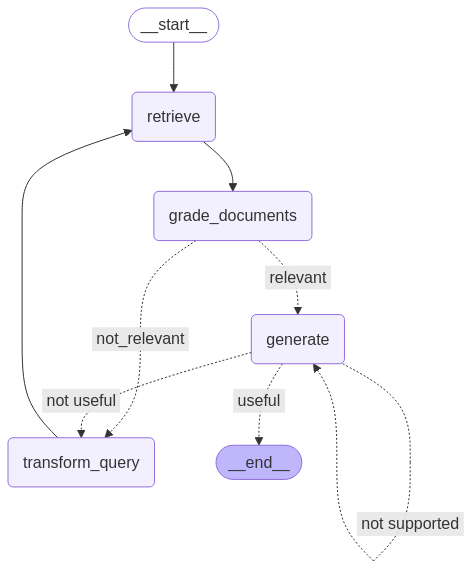

In [20]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Build workflow with lora

In [178]:
# 🔴 Fix: Prevent infinite document accumulation
def grade_documents(state):
    """Determines whether retrieved documents are relevant to the question."""
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = [
        d for d in documents if retrieval_grader.invoke({"question": question, "document": d.page_content}).binary_score == "yes"
    ]

    # ✅ Return only newly filtered documents, preventing infinite accumulation
    return {"documents": filtered_docs, "question": question}

# Modify the workflow logic
lora_workflow = StateGraph(GraphState)

# Add nodes
lora_workflow.add_node("retrieve", retrieve)
lora_workflow.add_node("grade_documents", grade_documents)
lora_workflow.add_node("generate_with_lora", generate_with_lora)
lora_workflow.add_node("transform_query", transform_query)

# Add edges
lora_workflow.add_edge(START, "retrieve")
lora_workflow.add_edge("retrieve", "grade_documents")
lora_workflow.add_edge("grade_documents", "generate_with_lora")

# 🔴 Fix: Ensure workflow stops after valid generation
lora_workflow.add_conditional_edges(
    "generate_with_lora",
    grade_generation_v_documents_and_question,
    {
        "useful": END,  # ✅ STOP workflow if answer is useful
        "not supported": END,  # ✅ STOP if unsupported
        "not useful": "transform_query",  # 🔄 Only retry if truly not useful
    },
)

# Compile the new workflow
app_with_lora = lora_workflow.compile()


## The Front-end

In [182]:
from pprint import pprint
# CLI front-end
def cli_interface():
    """Run CLI interface for user interaction."""
    while True:
        user_question = input("Enter your question (or type 'exit' to quit): ")
        if user_question.lower() == 'exit':
            break
        inputs = {"question": user_question}
        for output in app_with_lora.stream(inputs, config={"recursion_limit": 50}):
            for key, value in output.items():
                # Node
                pprint(f"Node '{key}':")
                # Optional: print full state at each node
                pprint(value, indent=2, width=80, depth=None)
            pprint("\n---\n")

if __name__ == "__main__":
    cli_interface()

---RETRIEVE---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'source': 'https://www.huffpost.com/entry/antony-blinken-russia-ukraine-invasion-update_n_6216d4d3e4b0f800ce1b82bf'}, page_content='“I can’t put a date or exact time on it, but everything is in place for Russia to move forward," the secretary of state said.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/white-house-putin-ukraine_n_62141d64e4b0f800ce162f93'}, page_content='A senior administration official said that since Russia had already been in that region since 2014, that "by itself would not be a new step."'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/russia-expels-us-deputy-chief-of-mission-in-moscow_n_620e5b3de4b0557b5a4053f7'}, page_content='The move comes amid heightened tensions between Russia and the U.S., fueled by fears that Moscow plans to invade Ukraine.')],
  'question': 'what happened in Russia?'}
'\n---\n'
---CHECK DOCUMENT RELEVAN

### Sample Output

In [108]:
from docx import Document as WordDocument  # Rename to avoid conflict
from langchain.schema import Document  # Import LangChain's Document
from docx.shared import Inches
import pprint
from PIL import Image

# Initialize Word document
doc = WordDocument()

test_questions = [
    "What news about puerto rico?",
    "What news about hurricane do you have?",
    "What happened in Russian?",
    "What happened in New York?",
    "What news about women do you have?"
]

runconfig = {"recursion_limit": 50}

for question in test_questions:
    print(f"\nQuestion: {question}")  # Print the question
    doc.add_paragraph(f"\nQuestion: {question}\n")

    inputs = {"question": question}
    for output in app.stream(inputs, config=runconfig):
        for key, value in output.items():
            print(f"Node '{key}':")  # Print node name
            print(pprint.pformat(value, indent=2, width=80))  # Print node output
            doc.add_paragraph(f"Node '{key}':")
            doc.add_paragraph(pprint.pformat(value, indent=2, width=80))

        print("\n---\n")  # Print separator
        doc.add_paragraph("\n---\n")

    final_output = value.get("generation", "No answer generated.")
    print(f"Final generation: {final_output}\n")  # Print final result
    doc.add_paragraph(f"Final generation: {final_output}\n")


Question: What news about puerto rico?
---RETRIEVE---
Node 'retrieve':
{ 'documents': [ Document(metadata={'source': 'https://www.huffpost.com/entry/tropical-storm-fiona-puerto-rico_n_6325d372e4b0ed021dfd719c'}, page_content='Puerto Rico was under a hurricane watch Saturday as the storm barreled towards the U.S. territory.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/alexandria-ocasio-cortez-steve-cortes-florida-sandals-feet_n_61cf9f2de4b04b42ab7441ee'}, page_content='The congresswoman fired back at Republican Steve Cortes, turning the tables on his bizarre crack about her trip to Florida with her boyfriend.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/hurricane-fiona_n_63281718e4b0ed021dfe4ff0'}, page_content='The storm knocked out the power grid and unleashed floods and landslides in Puerto Rico, where the governor said the damage was “catastrophic.”')],
  'question': 'What news about puerto rico?'}

---

---CHE

In [68]:
# Save the workflow graph
graph_image_path = "workflow_graph.png"
graph_bytes = app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

# Save the bytes as an image file
with open(graph_image_path, "wb") as f:
    f.write(graph_bytes)


# Add graph to the document
doc.add_paragraph("\nWorkflow Graph:")
doc.add_picture(graph_image_path, width=Inches(6))

# Save document
doc.save("output.docx")
print("Output saved to output.docx")

Output saved to output.docx


In [69]:
# Add a title
doc.add_heading("Multi-Agent System Summary", level=1)

# Add the summary text
summary_text = """This multi-agent system utilizes LangGraph to implement a structured retrieval-augmented generation (RAG) pipeline. The system is designed to process user queries by retrieving relevant documents, evaluating their relevance, generating responses, and iteratively refining the query when necessary. The workflow consists of interconnected nodes, each performing a specific task. The retrieval node fetches documents from a vector database, followed by a grading node that assesses their relevance. If the documents are deemed useful, the generation node produces an answer using an LLM. However, if the documents are irrelevant, the system redirects to a query transformation node to refine the question before retrying retrieval. The process continues until a high-quality response is generated. The system includes self-assessment mechanisms to verify whether the response is factual and directly answers the question. If the response is found lacking, the query is reformulated, and the process repeats. This design enables an adaptive, intelligent retrieval system that dynamically adjusts to input quality, ensuring accurate and reliable responses through iterative refinement."""

doc.add_paragraph(summary_text)

# Save the document
output_path = "output.docx"
doc.save(output_path)

print(f"Summary saved to {output_path}")

Summary saved to output.docx


## test the rag with lora

In [179]:
from docx import Document as WordDocument  # Rename to avoid conflict
from langchain.schema import Document  # Import LangChain's Document
from docx.shared import Inches
import pprint
from PIL import Image

# Initialize Word document
doc1 = WordDocument()

test_questions = [
    "What news about puerto rico?",
    "What news about hurricane do you have?",
    "What happened in Russian?",
    "What news about women do you have?"
]

runconfig = {"recursion_limit": 50}

for question in test_questions:
    print(f"\nQuestion: {question}")  # Print the question
    doc1.add_paragraph(f"\nQuestion: {question}\n")

    inputs = {"question": question}
    for output in app_with_lora.stream(inputs, config=runconfig):
        for key, value in output.items():
            print(f"Node '{key}':")  # Print node name
            print(pprint.pformat(value, indent=2, width=80))  # Print node output
            doc1.add_paragraph(f"Node '{key}':")
            doc1.add_paragraph(pprint.pformat(value, indent=2, width=80))

        print("\n---\n")  # Print separator
        doc1.add_paragraph("\n---\n")

    final_output = value.get("generation", "No answer generated.")
    print(f"Final generation: {final_output}\n")  # Print final result
    doc1.add_paragraph(f"Final generation: {final_output}\n")


Question: What news about puerto rico?
---RETRIEVE---
Node 'retrieve':
{ 'documents': [ Document(metadata={'source': 'https://www.huffpost.com/entry/tropical-storm-fiona-puerto-rico_n_6325d372e4b0ed021dfd719c'}, page_content='Puerto Rico was under a hurricane watch Saturday as the storm barreled towards the U.S. territory.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/alexandria-ocasio-cortez-steve-cortes-florida-sandals-feet_n_61cf9f2de4b04b42ab7441ee'}, page_content='The congresswoman fired back at Republican Steve Cortes, turning the tables on his bizarre crack about her trip to Florida with her boyfriend.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/hurricane-fiona_n_63281718e4b0ed021dfe4ff0'}, page_content='The storm knocked out the power grid and unleashed floods and landslides in Puerto Rico, where the governor said the damage was “catastrophic.”')],
  'question': 'What news about puerto rico?'}

---

---CHE

In [145]:
def base_llm_generate(question):
    """Generate a response using the base LLM without retrieval."""
    return llm.invoke(question)

In [146]:
# Function for RAG response
def rag_generate(question):
    """Generate a response using basic RAG (retrieval + LLM)."""
    docs = retriever.invoke(question)  # Retrieve documents
    return rag_chain.invoke({"context": docs, "question": question})

In [151]:
# Function for Advanced Agentic RAG (No Fine-Tuning) - Ensuring streaming works
def advanced_rag_generate(question):
    """Generate a response using the advanced agentic RAG without fine-tuning."""
    inputs = {"question": question}
    final_output = None  # Placeholder

    for output in app.stream(inputs, config=runconfig):
        for key, value in output.items():
            print(f"Node '{key}':")  # Print node name
            print(pprint.pformat(value, indent=2, width=80))  # Print node output
            
            if "generation" in value:
                final_output = value["generation"]

    return final_output if final_output else "No answer generated."


In [180]:
# Function for Advanced Agentic RAG (No Fine-Tuning) - Ensuring streaming works
def advanced_rag_with_lora_generate(question):
    """Generate a response using the advanced agentic RAG without fine-tuning."""
    inputs = {"question": question}
    final_output = None  # Placeholder

    for output in app_with_lora.stream(inputs, config=runconfig):
        for key, value in output.items():
            print(f"Node '{key}':")  # Print node name
            print(pprint.pformat(value, indent=2, width=80))  # Print node output
            
            if "generation" in value:
                final_output = value["generation"]

    return final_output if final_output else "No answer generated."


In [181]:
test_questions = [
    "What news about puerto rico?",
    "What news about hurricane do you have?",
    "What happened in Russian?",
    "What news about heath?",
    "What news about women do you have?"
]

# Define output file
output_file = "llm_rag_evaluation.txt"

with open(output_file, "w", encoding="utf-8") as file:
    for question in test_questions:
        #doc.add_paragraph(f"\nQuestion: {question}\n")
        print(f"\nQuestion: {question}")
        file.write(f"\nQuestion: {question}\n")

        # Get responses from different models
        base_llm_response = base_llm_generate(question)
        basic_rag_response = rag_generate(question)
        advanced_rag_response = advanced_rag_generate(question)
        lora_rag_response = advanced_rag_with_lora_generate(question) if lora_model else "Fine-tuned model not available."

        #Log results in the document
        results = {
            "Base LLM (No RAG)": base_llm_response,
            "Basic RAG": basic_rag_response,
            "Advanced Agentic RAG (No Fine-Tuning)": advanced_rag_response,
            "Advanced Agentic RAG (Fine-Tuned)": lora_rag_response

        }

        for key, response in results.items():
                print(f"{key}: {response}\n")
                file.write(f"{key}: {response}\n")

        print("\n---\n")
        file.write("\n---\n")

print(f"Results saved to {output_file}")


Question: What news about puerto rico?
---RETRIEVE---
Node 'retrieve':
{ 'documents': [ Document(metadata={'source': 'https://www.huffpost.com/entry/tropical-storm-fiona-puerto-rico_n_6325d372e4b0ed021dfd719c'}, page_content='Puerto Rico was under a hurricane watch Saturday as the storm barreled towards the U.S. territory.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/alexandria-ocasio-cortez-steve-cortes-florida-sandals-feet_n_61cf9f2de4b04b42ab7441ee'}, page_content='The congresswoman fired back at Republican Steve Cortes, turning the tables on his bizarre crack about her trip to Florida with her boyfriend.'),
                 Document(metadata={'source': 'https://www.huffpost.com/entry/hurricane-fiona_n_63281718e4b0ed021dfe4ff0'}, page_content='The storm knocked out the power grid and unleashed floods and landslides in Puerto Rico, where the governor said the damage was “catastrophic.”')],
  'question': 'What news about puerto rico?'}
---CHECK DOC

In [183]:
summary = """
As we transition from the base LLM to the advanced RAG with a fine-tuned agent, we observe notable improvements in response quality. The base LLM, while capable of generating coherent answers, often lacks grounding in retrieved documents, leading to occasional hallucinations. In contrast, the RAG-enhanced model effectively incorporates retrieved context, reducing misinformation and improving relevance. Further, the fine-tuned LoRA model enhances domain adaptation, allowing for more precise and contextually aware responses. Overall, the advanced RAG setup demonstrates superior factual consistency, improved contextual alignment, and higher response accuracy compared to the standalone base LLM.
"""

# File path
file_path = "llm_rag_evaluation.txt"

# Append the summary to the file
with open(file_path, "a") as file:
    file.write("\n\n" + summary)

print("Summary appended successfully.")

Summary appended successfully.
